# SMMALA sampling of MLP weights using XOR data

Learn the XOR function by sampling the weights of a multi-layer perceptron (MLP) via SMMALA.

In [1]:
## Import packages

import torch

from torch.utils.data import DataLoader

from eeyore.data import XOR
from eeyore.models import mlp
from eeyore.mcmc import SMMALA

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load XOR data

xor = XOR()
dataloader = DataLoader(xor, batch_size=4)

In [3]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[2, 2, 1])
model = mlp.MLP(hparams=hparams)

In [4]:
## Setup SMMALA sampler

theta0 = model.prior.sample()
sampler = SMMALA(model, theta0, dataloader, step=0.5)

In [5]:
## Run SMMALA sampler

sampler.run(num_iterations=11000, num_burnin=1000)

In [6]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.7894999980926514

In [7]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([-0.0271, -0.0354, -0.0028, -0.0317, -0.0337, -0.0517,  0.0056, -0.0378,
        -0.0164], dtype=torch.float64)

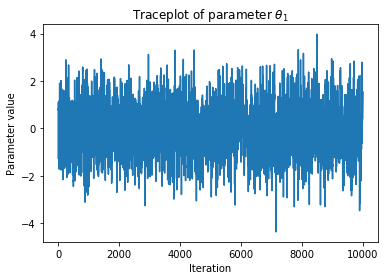

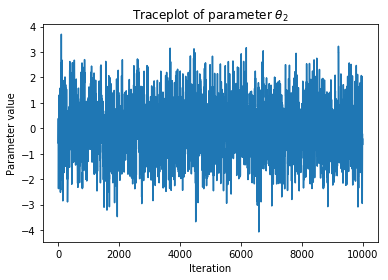

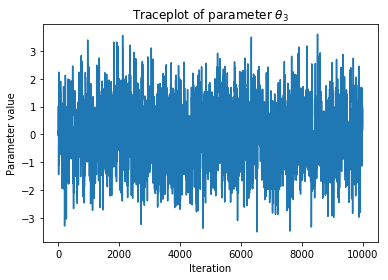

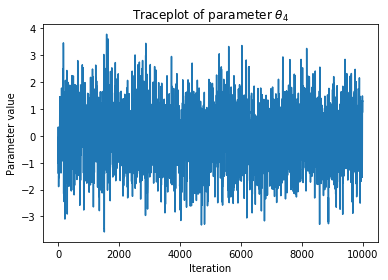

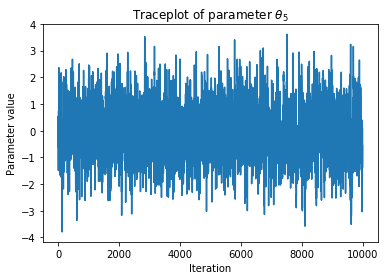

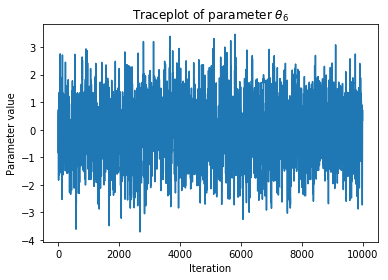

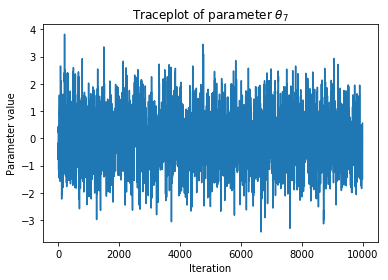

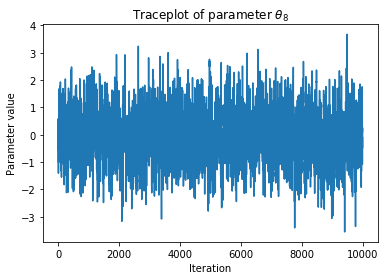

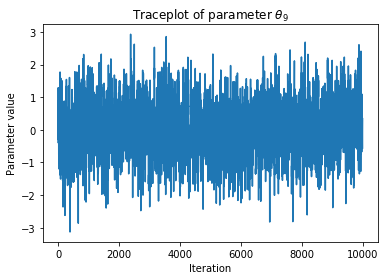

In [8]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter $\theta_{}$'.format(i+1))

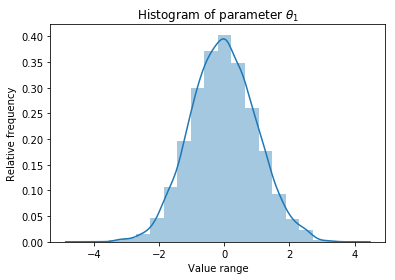

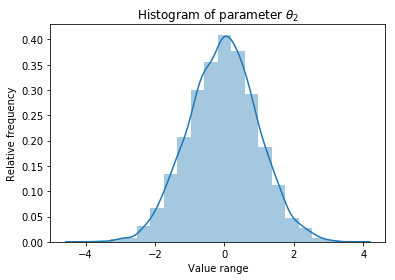

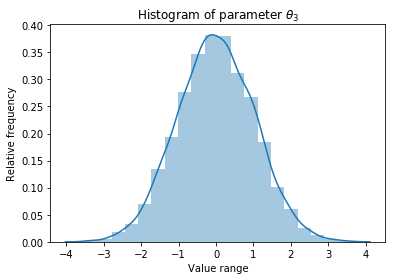

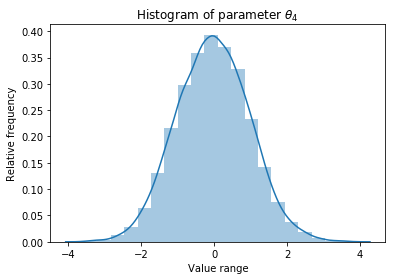

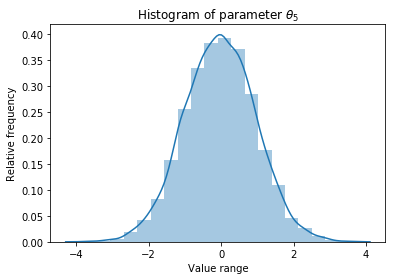

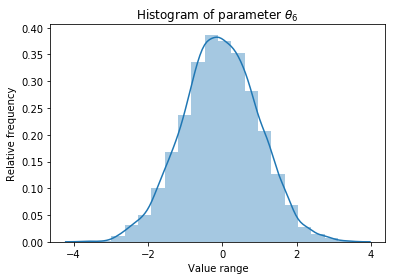

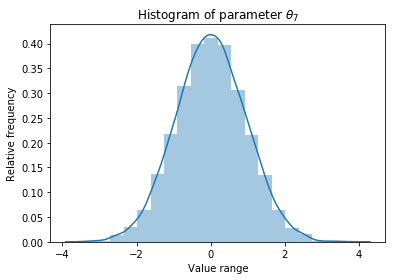

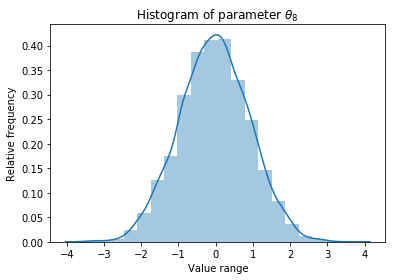

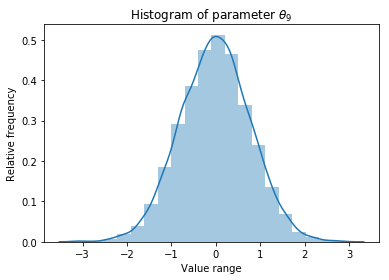

In [9]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(sampler.chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter $\theta_{}$'.format(i+1))